In [4]:
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
import os
import math
os.environ["WDS_VERBOSE_CACHE"] = "1"
os.environ["GOPEN_VERBOSE"] = "0"

import webdataset as wds

from utils import get_tar_files

# ALL_DATA_DIR = "/cluster/work/lawecon_repo/gravestones/shards/images"
SHARDS_DIR = "/cluster/work/lawecon_repo/gravestones/rep_learning_dataset/shards"

## 1. Load Data

In [5]:
# get all tar files from the dataset directory
tar_files = get_tar_files(SHARDS_DIR)
print(f"Found {len(tar_files)} tar files.")

# use the first tar file for testing
tar_file = tar_files[320]

# create webdataset object
dataset = wds.WebDataset(tar_file, resampled=True, shardshuffle=True).shuffle(1000).decode("pil")

assert isinstance(dataset, torch.utils.data.IterableDataset)
print(f"Dataset loaded from tar file: {tar_file}")

Found 1000 tar files.
Dataset loaded from tar file: /cluster/work/lawecon_repo/gravestones/rep_learning_dataset/shards/gravestones_shard_000765.tar


/cluster/home/jiapan/miniforge3/envs/gravestones/lib/python3.12/site-packages/webdataset/compat.py:377: UserWarning: WebDataset(shardshuffle=...) is ignored for resampled datasets
  warnings.warn("WebDataset(shardshuffle=...) is ignored for resampled datasets")
/cluster/home/jiapan/miniforge3/envs/gravestones/lib/python3.12/site-packages/webdataset/compat.py:381: UserWarning: set WebDataset(shardshuffle=...) to a positive integer or 0 or False
  warnings.warn("set WebDataset(shardshuffle=...) to a positive integer or 0 or False")


### show some

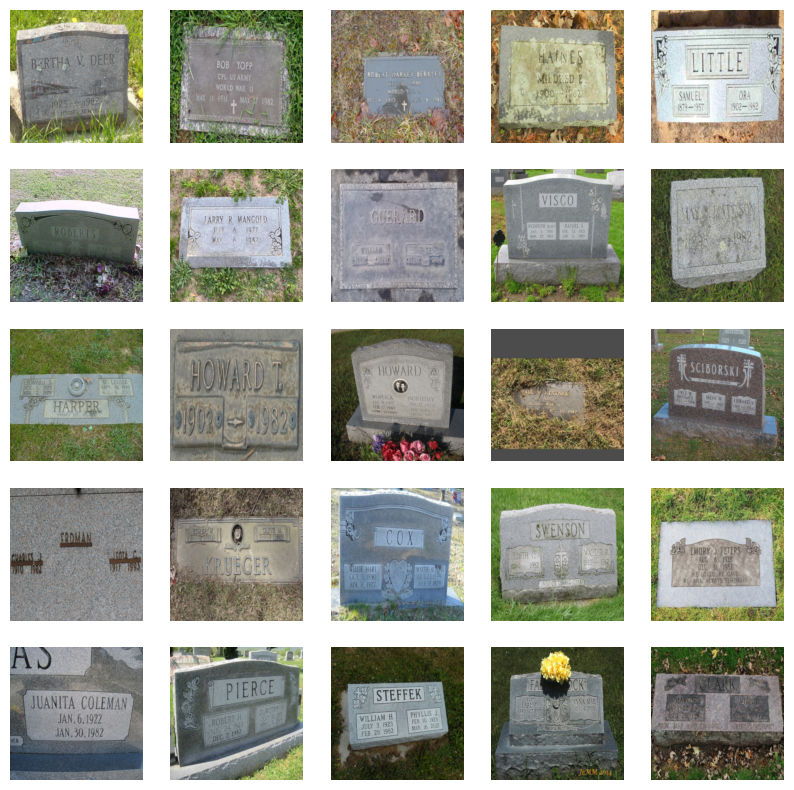

In [6]:
num_images = 25
num_cols = 5

num_rows = math.ceil(num_images/num_cols)
layout = (num_rows, num_cols)
fig, axes = plt.subplots(*layout, figsize=(10, 2 * num_rows))
for i, img_dict in enumerate(dataset):
    if i >= num_images:
        break
    image = img_dict["jpg"] if "jpg" in img_dict else img_dict["png"]
    ax = axes[i // layout[1], i % layout[1]]
    ax.imshow(image)
    ax.axis('off')

## 2. Define some transformations

In [7]:
transform_train = transforms.Compose(
    [   
        # transforms.Resize((256, 256)),
        # transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

def make_sample(sample):
    image = sample["jpg"] if "jpg" in sample else sample["png"]
    return (transform_train(image),)

## 3. Apply transformations & Batchify

In [8]:
train_set = dataset.map(make_sample).batched(64)

num_cpus = os.cpu_count()
print("Detected CPUs:", num_cpus)
train_loader = wds.WebLoader(train_set, batch_size=None, num_workers=num_cpus)

# Unbatch, shuffle between workers, then rebatch.
train_loader = train_loader.unbatched().shuffle(10).batched(64)

# Since we are using resampling, the dataset is infinite; set an artificial epoch size (number of batches per epoch).
train_loader = train_loader.with_epoch(10)

Detected CPUs: 4


In [9]:
images, = next(iter(train_loader))

In [10]:
print(type(images))
print(images.shape)

<class 'torch.Tensor'>
torch.Size([64, 3, 256, 256])
